In [1]:
import pandas as pd
import numpy as np
import networkx as nx
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import accuracy_score, f1_score, classification_report, calinski_harabaz_score
from sklearn.metrics import precision_score, recall_score, confusion_matrix
from sklearn.model_selection import train_test_split
from sklearn.model_selection import GridSearchCV
from sklearn.linear_model import LogisticRegression
from sklearn.pipeline import Pipeline
from sklearn.decomposition import TruncatedSVD
from sklearn import svm
from sklearn.ensemble import RandomForestClassifier
from sklearn.preprocessing import StandardScaler
import scipy as sp
import itertools
from nltk import word_tokenize
import warnings
import xgboost as xgb
warnings.filterwarnings('ignore')
from sklearn.cluster import KMeans
%matplotlib inline

In [8]:
G= nx.read_gexf('/storage/twitter_network.gexf')

In [9]:
nodes_in_credbank = []
for node in G.nodes():
    if G.node[node]['more_than_5_percent_fake'] != "b'notweets'":
        nodes_in_credbank.append(node)

In [10]:
sub_graph = G.subgraph(nodes_in_credbank)

In [11]:
real_sources = []
fake_sources = []
for node in sub_graph.nodes():
    if sub_graph.node[node]['more_than_5_percent_fake'] == "b'True'":
        fake_sources.append(node)
    else:
        real_sources.append(node)

### Modularity Community Detection on Verified Users > 1m Followers
Modularity maximization begins with each node in its own community and joins the pair of communities that most increases modularity until no such pair exists. Networks with high modularity have dense connections between the nodes within modules but sparse connections between nodes in different modules.


![title](/storage/screenshot_074045.png)

![tile](/storage/communities-size-distribution.png)

![title](/storage/final.png)

#### Full Network Graph (CredBank Sources Only)
![title](/storage/full_graph2.png)

#### Network Graph with Just "Fake Sources"
![title](/storage/fake_only.png)

### Network EDA

#### Eigenvector Centrality
eigenvector centrality is a measure of the influence of a node in a network. Relative scores are assigned to all nodes in the network based on the concept that connections to high-scoring nodes contribute more to the score of the node in question than equal connections to low-scoring nodes. A high eigenvector score means that a node is connected to many nodes who themselves have high scores.

In [83]:
stats_from_gephi = pd.read_csv('/storage/louvain.csv')

In [7]:
ev_df = stats_from_gephi[['Id', 'eigencentrality']]
ev_df.Id = ev_df.Id.apply(lambda x: str(x))
ev_df.set_index('Id', inplace=True)

/opt/conda/lib/python3.6/site-packages/pandas/core/generic.py:4405: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  self[name] = value


In [8]:
real_ev = []
fake_ev = []
for x in real_sources:
    real_ev.append(ev_df.eigencentrality.loc[x])
for x in fake_sources:
    fake_ev.append(ev_df.eigencentrality.loc[x])

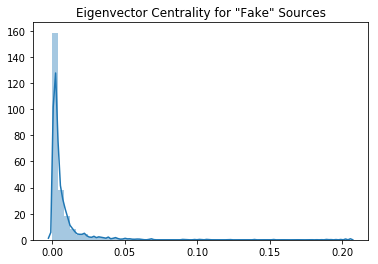

In [9]:
sns.distplot(fake_ev)
plt.title('Eigenvector Centrality for "Fake" Sources')
plt.show()

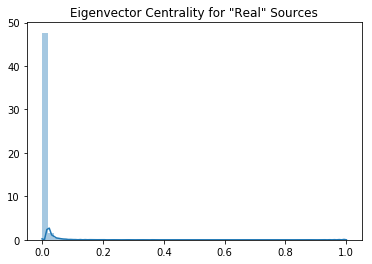

In [10]:
sns.distplot(real_ev)
plt.title('Eigenvector Centrality for "Real" Sources')
plt.show()

#### Page Rank
PageRank is widely recognized as a way of detecting influential nodes in a graph. It is different to other centrality algorithms because the influence of a node depends on the influence of its neighbours.

In [11]:
pg_rnk = nx.algorithms.pagerank(sub_graph)

In [12]:
pg_real = []
pg_fk = []
for x in real_sources:
    pg_real.append(pg_rnk[x])
for x in fake_sources:
    pg_fk.append(pg_rnk[x])

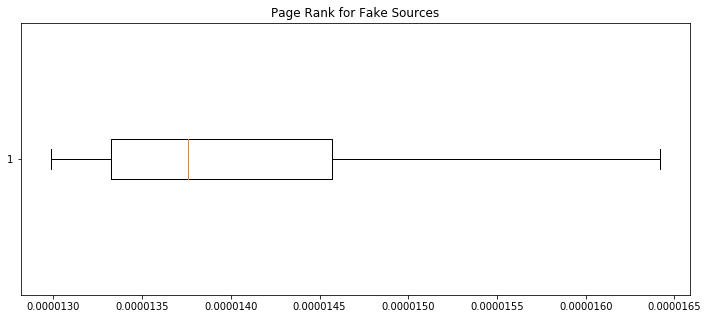

In [13]:
plt.figure(figsize=(12,5))
plt.boxplot(pg_fk, showfliers=False, vert=False)
plt.title("Page Rank for Fake Sources")
plt.show()

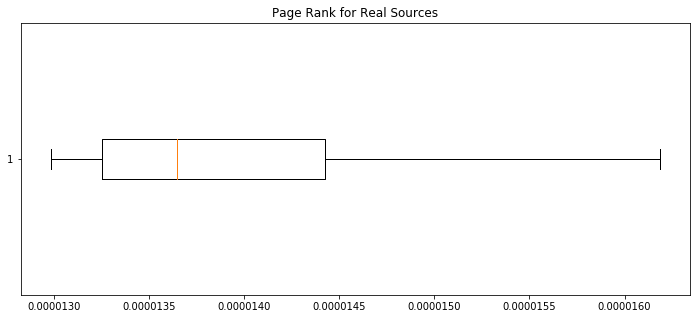

In [14]:
plt.figure(figsize=(12,5))
plt.boxplot(pg_real, showfliers=False, vert=False)
plt.title("Page Rank for Real Sources")
plt.show()

## Clustering

### Louvain Community Detection
The Louvain method of community detection is an algorithm for detecting communities in networks. It maximizes a modularity score for each community, where the modularity quantifies the quality of an assignment of nodes to communities by evaluating how much more densely connected the nodes within a community are compared to how connected they would be in a random network.

![title](/storage/louvain_full.png)

![title](/storage/louvain_partition.png)

In [3]:
louvain_df = stats_from_gephi[['Id', 'Cluster']]
louvain_df.Id = louvain_df.Id.apply(lambda x: str(x))
louvain_df.set_index('Id', inplace=True)
louvain_df.head()

,Cluster
Id,
28835,0
204136,0
111815,171
36410,27
106949,0


In [21]:
louvain_df['Fake'] = louvain_df.Id.apply(lambda x: x in fake_sources)

/opt/conda/lib/python3.6/site-packages/ipykernel_launcher.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  """Entry point for launching an IPython kernel.


In [23]:
real_clusters = set(list(louvain_df[louvain_df['Fake'] == False].Cluster))
fake_clusters = set(list(louvain_df[louvain_df['Fake'] == True].Cluster))
both = real_clusters.intersection(fake_clusters)

In [24]:
total_eliminated = 0
for x in list(louvain_df[louvain_df['Fake'] == False].Cluster):
    if x not in both:
        total_eliminated +=1

In [25]:
print(f"Total real nodes eliminated through clustering: {total_eliminated}")

Total real nodes eliminated through clustering: 25838


## Node2Vec
The node2vec framework learns low-dimensional representations for nodes in a graph by optimizing a neighborhood preserving objective. The objective is flexible, and the algorithm accomodates for various definitions of network neighborhoods by simulating biased random walks. Specifically, it provides a way of balancing the exploration-exploitation tradeoff that in turn leads to representations obeying a spectrum of equivalences from homophily to structural equivalence.

In [52]:
from node2vec import Node2Vec

In [68]:
node2vec = Node2Vec(sub_graph, dimensions=128, walk_length=30, num_walks=200, workers=1, p=.5, q=3)

Generating walks (CPU: 1): 100%|██████████| 200/200 [02:57<00:00,  1.34it/s]


In [69]:
vmodel = node2vec.fit()

In [70]:
vmodel.wv.save_word2vec_format('/storage/node2.emb')

In [71]:
emb_df = pd.read_csv('/storage/node2.emb', sep=' ', skiprows=[0], header=None)
emb_df[0] = emb_df[0].apply(lambda x: str(x))
emb_df.set_index(0, inplace=True)
emb_df.index.name = 'node'
emb_df.head()

,1,2,3,4,5,6,7,8,9,10,...,119,120,121,122,123,124,125,126,127,128
node,,,,,,,,,,,,,,,,,,,,,
34,1.215360,0.590668,1.206217,0.815922,0.474462,-0.184177,-1.022098,0.046622,0.482609,0.775657,...,-0.691533,-0.624864,0.367276,-0.179574,-0.417812,-2.118079,0.572015,-1.895707,0.440647,-1.368375
47066,0.644473,0.134478,1.372650,0.565117,0.662336,0.190529,-0.986900,0.083679,0.505446,1.097492,...,-0.573227,0.005819,0.573356,0.010229,-0.498130,-1.716094,1.317506,-1.257594,0.891697,-0.840043
935,1.025927,0.489599,1.326657,0.735876,0.547768,-0.009837,-0.993691,0.451789,0.431461,0.718527,...,-0.812079,0.002490,0.557994,0.410985,-0.405380,-1.914024,0.909353,-1.462142,0.676795,-1.100042
2839,-0.039276,-1.585982,2.685040,2.921607,-0.387245,0.233172,-0.201593,-0.933081,-0.486840,2.291283,...,-2.844961,0.864968,0.400546,0.538342,0.417391,0.317565,0.875755,-3.282280,-0.698688,0.563220
2949,1.050536,-1.051138,0.737621,1.115862,0.915033,1.424241,0.604096,2.238234,1.334923,0.457917,...,0.627566,-0.319493,1.937815,2.045055,1.151095,-2.276983,2.361725,-2.611036,0.388171,-0.119152


### Using Profile Descriptions for Neural Net Word Embeddings
Embedding Layer inside of a Deep Neural Network to compute  word embedding vectors. Word Embeddings are a type of vectorization strategy that computes word vectors from a text corpus by training a neural network, which results in a high-dimensional embedding space, where each word is in the corpus is a unique vector in that space. In this embedding space, the position of the vector relative to the other vectors captures semantic meaning. 

In [3]:
from keras.preprocessing.sequence import pad_sequences
from keras.layers import Input, Dense, LSTM, Embedding, GRU
from keras.layers import Dropout, Activation, Bidirectional, GlobalMaxPool1D
from keras.models import Model
from keras import initializers, regularizers, constraints, optimizers, layers
from keras.preprocessing import text, sequence

Using TensorFlow backend.


In [90]:
descriptions_df = stats_from_gephi[['Id', '7']]
descriptions_df.Id = descriptions_df.Id.apply(lambda x: str(x))
descriptions_df.set_index('Id', inplace=True)
nodes = list(descriptions_df.index)
nodes = [str(node) for node in nodes]
target = []
real_set = set(real_sources)
for node in nodes:
    if node in real_set:
        target.append(0)
    else:
        target.append(1)

In [92]:
descriptions_df['target'] = target
descriptions_df.rename(columns={'7': 'description'}, inplace=True)


,description,target
Id,,
28835,"b'Editora de moda, apresentadora, jornalista e...",0
204136,b'I cover D.C. government for @WashingtonPost....,0
111815,b'Scribbler: Music Ally / Observer / The Week ...,0
36410,b'home of entertainment since 1921. Rewards: @...,0
106949,"b'News Anchor & Presenter BBC World News - ""Ta...",0


In [93]:
descriptions_df.description = descriptions_df.description.apply(lambda x: x.replace("b'", ""))

In [95]:
descriptions_df.description = descriptions_df.description.apply(lambda x: x.replace('b"', ""))

In [141]:
target = descriptions_df.target
data = descriptions_df['description'].map(word_tokenize).values


In [146]:
y = pd.get_dummies(target).values
tokenizer = text.Tokenizer(num_words=50000)
tokenizer.fit_on_texts(list(descriptions_df.description))
list_tokenized_headlines = tokenizer.texts_to_sequences(descriptions_df.description)
X_t = sequence.pad_sequences(list_tokenized_headlines, maxlen=50)

In [4]:
embedding_size = 128
input_ = Input(shape=(20,))
x = Embedding(50000, embedding_size)(input_)
x = LSTM(25, return_sequences=True)(x)
x = GlobalMaxPool1D()(x)
x = Dropout(0.5)(x)
x = Dense(50, activation='relu')(x)
x = Dropout(0.5)(x)
# There are 41 different possible classes, so we use 41 neurons in our output layer
x = Dense(2, activation='softmax')(x)

model = Model(inputs=input_, outputs=x)

In [5]:
model.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy'])

In [6]:
model.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         (None, 20)                0         
_________________________________________________________________
embedding_1 (Embedding)      (None, 20, 128)           6400000   
_________________________________________________________________
lstm_1 (LSTM)                (None, 20, 25)            15400     
_________________________________________________________________
global_max_pooling1d_1 (Glob (None, 25)                0         
_________________________________________________________________
dropout_1 (Dropout)          (None, 25)                0         
_________________________________________________________________
dense_1 (Dense)              (None, 50)                1300      
_________________________________________________________________
dropout_2 (Dropout)          (None, 50)                0         
__________

In [110]:
model.fit(X_t, y, epochs=2, batch_size=50, validation_split=0.1)

Train on 62122 samples, validate on 6903 samples
Epoch 1/2
62122/62122 [==============================] - 84s 1ms/step - loss: 0.1770 - acc: 0.9629 - val_loss: 0.1418 - val_acc: 0.9673
Epoch 2/2
62122/62122 [==============================] - 83s 1ms/step - loss: 0.1376 - acc: 0.9649 - val_loss: 0.1520 - val_acc: 0.9673


In [7]:
embedding_size = 128
input_ = Input(shape=(50,))
x = Embedding(50000, embedding_size)(input_)
x = GRU(50, return_sequences=True)(x)
x = GlobalMaxPool1D()(x)
x = Dropout(0.5)(x)
x = Dense(50, activation='relu')(x)
x = Dropout(0.5)(x)

x = Dense(2, activation='softmax')(x)

model = Model(inputs=input_, outputs=x)

In [8]:
model.compile(loss='categorical_crossentropy', optimizer='rmsprop', metrics=['accuracy'])

In [9]:
model.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_2 (InputLayer)         (None, 50)                0         
_________________________________________________________________
embedding_2 (Embedding)      (None, 50, 128)           6400000   
_________________________________________________________________
gru_1 (GRU)                  (None, 50, 50)            26850     
_________________________________________________________________
global_max_pooling1d_2 (Glob (None, 50)                0         
_________________________________________________________________
dropout_3 (Dropout)          (None, 50)                0         
_________________________________________________________________
dense_3 (Dense)              (None, 50)                2550      
_________________________________________________________________
dropout_4 (Dropout)          (None, 50)                0         
__________

In [185]:
model.fit(X_t, y, epochs=5, batch_size=1000, validation_split=0.1)

Train on 62122 samples, validate on 6903 samples
Epoch 1/5
62122/62122 [==============================] - 23s 367us/step - loss: 0.2178 - acc: 0.9607 - val_loss: 0.1453 - val_acc: 0.9673
Epoch 2/5
62122/62122 [==============================] - 19s 301us/step - loss: 0.1633 - acc: 0.9649 - val_loss: 0.1430 - val_acc: 0.9673
Epoch 3/5
62122/62122 [==============================] - 19s 300us/step - loss: 0.1506 - acc: 0.9649 - val_loss: 0.1487 - val_acc: 0.9673
Epoch 4/5
62122/62122 [==============================] - 19s 302us/step - loss: 0.1336 - acc: 0.9650 - val_loss: 0.1557 - val_acc: 0.9673
Epoch 5/5
62122/62122 [==============================] - 19s 298us/step - loss: 0.1149 - acc: 0.9652 - val_loss: 0.1715 - val_acc: 0.9667


In [186]:
preds = model.predict(X_t)

In [192]:
descriptions_df['preds'] = [x[1] for x in preds]
descriptions_df.head()

,description,target,preds
Id,,,
28835,"Editora de moda, apresentadora, jornalista e e...",0,0.007872
204136,I cover D.C. government for @WashingtonPost. S...,0,0.242138
111815,Scribbler: Music Ally / Observer / The Week Ju...,0,0.058281
36410,home of entertainment since 1921. Rewards: @pu...,0,0.086661
106949,"News Anchor & Presenter BBC World News - ""Talk...",0,0.045177


In [195]:
emb_and_desc_score = emb_df.join(descriptions_df.drop(columns=['description']))

In [ ]:
emb_and_desc_score.head()

In [201]:
emb_and_desc_score.to_csv('/storage/emb_and_desc_score.csv')

## Classifiers
Combining probabilities from neural network with vectors from node2vev

In [10]:
emb_and_desc_score = pd.read_csv('/storage/emb_and_desc_score.csv')

In [11]:
X = emb_and_desc_score.drop(columns=['target'])
y= emb_and_desc_score.target

In [12]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=.3)

In [13]:
scaler = StandardScaler()
scaled_X_train = scaler.fit_transform(X_train)
scaled_X_test = scaler.transform(X_test)

In [14]:
xgb_clf = xgb.XGBClassifier()
param_grid = {
    "learning_rate": [.05, .01],
    'max_depth': [6, 10],
    'min_child_weight': [1, 5],
    'subsample': [ 0.7],
    'n_estimators': [100, 250],
}
grid_xgb = GridSearchCV(xgb_clf, param_grid, scoring='recall', cv=None, n_jobs=1, verbose=10)
grid_xgb.fit(scaled_X_train, y_train)

best_parameters = grid_xgb.best_params_

print("Grid Search found the following optimal parameters: ")
for param_name in sorted(best_parameters.keys()):
    print("%s: %r" % (param_name, best_parameters[param_name]))

training_preds = grid_xgb.predict(scaled_X_train)
val_preds = grid_xgb.predict(scaled_X_test)
training_accuracy = accuracy_score(y_train, training_preds)
val_accuracy = accuracy_score(y_test, val_preds)

print("")
print("Training Accuracy: {:.4}%".format(training_accuracy * 100))
print("Validation accuracy: {:.4}%".format(val_accuracy * 100))

Fitting 3 folds for each of 16 candidates, totalling 48 fits
[CV] learning_rate=0.05, max_depth=6, min_child_weight=1, n_estimators=100, subsample=0.7 


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


[CV]  learning_rate=0.05, max_depth=6, min_child_weight=1, n_estimators=100, subsample=0.7, score=0.3641304347826087, total=  46.4s
[CV] learning_rate=0.05, max_depth=6, min_child_weight=1, n_estimators=100, subsample=0.7 


[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:   46.6s remaining:    0.0s


[CV]  learning_rate=0.05, max_depth=6, min_child_weight=1, n_estimators=100, subsample=0.7, score=0.36594202898550726, total=  46.0s
[CV] learning_rate=0.05, max_depth=6, min_child_weight=1, n_estimators=100, subsample=0.7 


[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:  1.5min remaining:    0.0s


[CV]  learning_rate=0.05, max_depth=6, min_child_weight=1, n_estimators=100, subsample=0.7, score=0.36231884057971014, total=  46.0s
[CV] learning_rate=0.05, max_depth=6, min_child_weight=1, n_estimators=250, subsample=0.7 


[Parallel(n_jobs=1)]: Done   3 out of   3 | elapsed:  2.3min remaining:    0.0s


[CV]  learning_rate=0.05, max_depth=6, min_child_weight=1, n_estimators=250, subsample=0.7, score=0.3532608695652174, total= 2.0min
[CV] learning_rate=0.05, max_depth=6, min_child_weight=1, n_estimators=250, subsample=0.7 


[Parallel(n_jobs=1)]: Done   4 out of   4 | elapsed:  4.3min remaining:    0.0s


[CV]  learning_rate=0.05, max_depth=6, min_child_weight=1, n_estimators=250, subsample=0.7, score=0.36594202898550726, total= 2.0min
[CV] learning_rate=0.05, max_depth=6, min_child_weight=1, n_estimators=250, subsample=0.7 


[Parallel(n_jobs=1)]: Done   5 out of   5 | elapsed:  6.3min remaining:    0.0s


[CV]  learning_rate=0.05, max_depth=6, min_child_weight=1, n_estimators=250, subsample=0.7, score=0.3641304347826087, total= 2.0min
[CV] learning_rate=0.05, max_depth=6, min_child_weight=5, n_estimators=100, subsample=0.7 


[Parallel(n_jobs=1)]: Done   6 out of   6 | elapsed:  8.3min remaining:    0.0s


[CV]  learning_rate=0.05, max_depth=6, min_child_weight=5, n_estimators=100, subsample=0.7, score=0.36594202898550726, total=  43.5s
[CV] learning_rate=0.05, max_depth=6, min_child_weight=5, n_estimators=100, subsample=0.7 


[Parallel(n_jobs=1)]: Done   7 out of   7 | elapsed:  9.1min remaining:    0.0s


[CV]  learning_rate=0.05, max_depth=6, min_child_weight=5, n_estimators=100, subsample=0.7, score=0.358695652173913, total=  44.1s
[CV] learning_rate=0.05, max_depth=6, min_child_weight=5, n_estimators=100, subsample=0.7 


[Parallel(n_jobs=1)]: Done   8 out of   8 | elapsed:  9.8min remaining:    0.0s


[CV]  learning_rate=0.05, max_depth=6, min_child_weight=5, n_estimators=100, subsample=0.7, score=0.3786231884057971, total=  43.7s
[CV] learning_rate=0.05, max_depth=6, min_child_weight=5, n_estimators=250, subsample=0.7 


[Parallel(n_jobs=1)]: Done   9 out of   9 | elapsed: 10.5min remaining:    0.0s


[CV]  learning_rate=0.05, max_depth=6, min_child_weight=5, n_estimators=250, subsample=0.7, score=0.35688405797101447, total= 1.9min
[CV] learning_rate=0.05, max_depth=6, min_child_weight=5, n_estimators=250, subsample=0.7 
[CV]  learning_rate=0.05, max_depth=6, min_child_weight=5, n_estimators=250, subsample=0.7, score=0.358695652173913, total= 1.9min
[CV] learning_rate=0.05, max_depth=6, min_child_weight=5, n_estimators=250, subsample=0.7 
[CV]  learning_rate=0.05, max_depth=6, min_child_weight=5, n_estimators=250, subsample=0.7, score=0.37681159420289856, total= 1.9min
[CV] learning_rate=0.05, max_depth=10, min_child_weight=1, n_estimators=100, subsample=0.7 
[CV]  learning_rate=0.05, max_depth=10, min_child_weight=1, n_estimators=100, subsample=0.7, score=0.36231884057971014, total= 1.2min
[CV] learning_rate=0.05, max_depth=10, min_child_weight=1, n_estimators=100, subsample=0.7 
[CV]  learning_rate=0.05, max_depth=10, min_child_weight=1, n_estimators=100, subsample=0.7, score=0.35

[Parallel(n_jobs=1)]: Done  48 out of  48 | elapsed: 79.0min finished


Grid Search found the following optimal parameters: 
learning_rate: 0.01
max_depth: 6
min_child_weight: 1
n_estimators: 250
subsample: 0.7

Training Accuracy: 97.8%
Validation accuracy: 97.1%


In [15]:
precision_score(y_test, val_preds)

0.7078651685393258

In [16]:
recall_score(y_test, val_preds)

0.33689839572192515

In [17]:
f1_score(y_test, val_preds)

0.45652173913043481

In [19]:
def plot_confusion_matrix(cm, classes,
                          normalize=False,
                          title='Confusion matrix',
                          cmap=plt.cm.Blues):
    #Add Normalization Option
    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
        print("Normalized confusion matrix")
    else:
        print('Confusion matrix, without normalization')

    print(cm)

    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=45)
    plt.yticks(tick_marks, classes)

    fmt = '.2f' if normalize else 'd'
    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, format(cm[i, j], fmt),
                 horizontalalignment="center",
                 color="white" if cm[i, j] > thresh else "black")

    plt.tight_layout()
    plt.ylabel('True label')
    plt.xlabel('Predicted label')

Confusion matrix, without normalization
[[19856   104]
 [  496   252]]


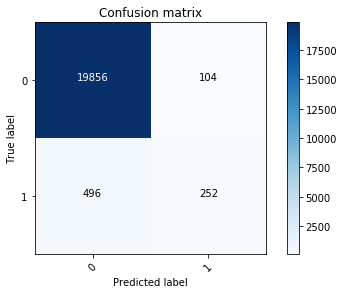

In [20]:
cm = confusion_matrix(y_test, val_preds)
plot_confusion_matrix(cm, ['0', '1'])

In [25]:
svm_clf = svm.SVC()
param_grid_svm = {'C': [1, 10], 'gamma': [0.001, 0.01], 'kernel': ['rbf']}
 

In [26]:
grid_svm = GridSearchCV(svm_clf, param_grid_svm, scoring="recall", cv=None, n_jobs=1)
grid_svm.fit(scaled_X_train, y_train)

best_parameters = grid_svm.best_params_

print("Grid Search found the following optimal parameters: ")
for param_name in sorted(best_parameters.keys()):
    print("%s: %r" % (param_name, best_parameters[param_name]))

training_preds = grid_svm.predict(scaled_X_train)
val_preds = grid_svm.predict(scaled_X_test)
training_accuracy = accuracy_score(y_train, training_preds)
val_accuracy = accuracy_score(y_test, val_preds)

print("")
print("Training Accuracy: {:.4}%".format(training_accuracy * 100))
print("Validation accuracy: {:.4}%".format(val_accuracy * 100))

Grid Search found the following optimal parameters: 
C: 10
gamma: 0.01
kernel: 'rbf'

Training Accuracy: 97.59%
Validation accuracy: 97.07%


In [27]:
precision_score(y_test, val_preds)

0.69315068493150689

In [28]:
recall_score(y_test, val_preds)

0.33823529411764708

In [29]:
f1_score(y_test, val_preds)

0.45462713387241693

Confusion matrix, without normalization
[[19848   112]
 [  495   253]]


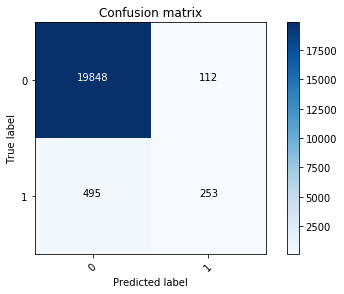

In [30]:
cm = confusion_matrix(y_test, val_preds)
plot_confusion_matrix(cm, ['0', '1'])

### K Means Clustering

In [16]:
X = emb_df.drop(columns=['target'])

In [17]:
y = emb_df.target

In [52]:
k_means_10 = KMeans(n_clusters=10).fit(X)
k_means_20 = KMeans(n_clusters=20).fit(X)
k_means_50 = KMeans(n_clusters=50).fit(X)
k_means_100 = KMeans(n_clusters=100).fit(X)
k_means_200 = KMeans(n_clusters=200).fit(X)
k_list = [k_means_10, k_means_20, k_means_50, k_means_100, k_means_200]

In [53]:
CH_score = []

for model in k_list:
    labels = model.labels_
    CH_score.append(calinski_harabaz_score(X, labels))

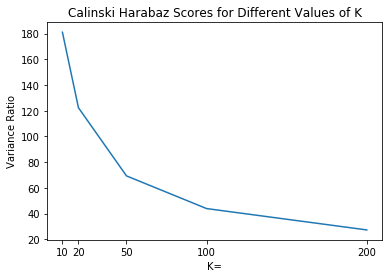

In [54]:
plt.plot([10, 20, 50, 100, 200], CH_score)
plt.xticks([10,20,50,100,200])
plt.title("Calinski Harabaz Scores for Different Values of K")
plt.ylabel("Variance Ratio")
plt.xlabel("K=")
plt.show()

In [67]:
k_200_preds = k_means_200.predict(X)

In [68]:
cluster_df = emb_df[['target']]

In [69]:
cluster_df['cluster'] = k_100_preds

/opt/conda/lib/python3.6/site-packages/ipykernel_launcher.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  """Entry point for launching an IPython kernel.
